In [1]:
%matplotlib inline

In [5]:
import os
import sys

spark_home = os.environ['SPARK_HOME']
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.4-src.zip'))

In [6]:
from __future__ import print_function, division
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.sql import SparkSession
from numpy import array
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession.builder.master("local") \
   .appName("test") \
   .enableHiveSupport() \
   .getOrCreate()

sc = spark.sparkContext

In [11]:
!head ../data/kmeans_data.txt

5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
4.6,3.4,1.4,0.3,Iris-setosa
5.0,3.4,1.5,0.2,Iris-setosa
4.4,2.9,1.4,0.2,Iris-setosa
4.9,3.1,1.5,0.1,Iris-setosa


In [12]:
!hadoop fs -put ../data/kmeans_data.txt /data/

In [13]:
# Load and parse the data
data = sc.textFile("/data/kmeans_data.txt")
parsedData = data.map(lambda line: line.split(',')[:4]).map(lambda line: array([float(x) for x in line]))



In [14]:
parsedData.take(5)

[array([5.1, 3.5, 1.4, 0.2]),
 array([4.9, 3. , 1.4, 0.2]),
 array([4.7, 3.2, 1.3, 0.2]),
 array([4.6, 3.1, 1.5, 0.2]),
 array([5. , 3.6, 1.4, 0.2])]

In [15]:
# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 5, maxIterations=20, initializationMode="random")


In [16]:
clusters.centers

[array([6.608, 3.064, 5.552, 2.128]),
 array([5.006, 3.418, 1.464, 0.244]),
 array([7.54, 3.15, 6.39, 2.09]),
 array([6.23513514, 2.84594595, 4.78378378, 1.5972973 ]),
 array([5.53214286, 2.63571429, 3.96071429, 1.22857143])]

In [17]:
# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))


Within Set Sum of Squared Error = 76.62135001208124


In [18]:
WSSSE_list = []

for k in range(2, 20):
    clusters = KMeans.train(parsedData, k, maxIterations=10, initializationMode="random")
    WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    WSSSE_list.append((WSSSE))
    

In [19]:
WSSSE_list

[128.40419523672944,
 122.47870583058848,
 83.72906657028327,
 88.34542302873378,
 73.88273040044345,
 66.37491684526996,
 70.82599290189391,
 61.21067784159958,
 58.16539672492754,
 57.191526138894254,
 54.23543197718012,
 53.96429371248475,
 52.457811858021884,
 51.94284085930952,
 50.487921780083,
 49.946370016502215,
 47.87975354008874,
 48.20977929856621]

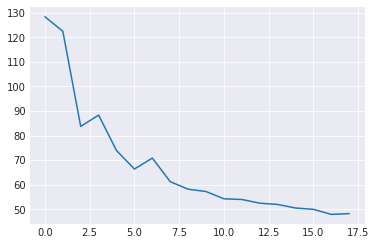

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 34638)
Traceback (most recent call last):
  File "/usr/lib64/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib64/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib64/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib64/python3.6/socketserver.py", line 696, in __init__
    self.handle()
  File "/workspace/spark/python/pyspark/accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "/workspace/spark/python/pyspark/serializers.py", line 581, in read_int
    raise EOFError
EOFError
----------------------------------------


In [20]:
sns.set_style("darkgrid")
plt.plot(WSSSE_list)
plt.show()

In [35]:
spark.stop()